# Delineate snowlines

## Must already have classified images available in file

In [ ]:
# !pip install rioxarray geedim wxee

In [1]:
import glob
import os
import pandas as pd
import geopandas as gpd
import ee
import matplotlib.pyplot as plt
import sys
import json
import xarray as xr
import rioxarray as rxr
import numpy as np
from tqdm.auto import tqdm
from scipy.ndimage import binary_fill_holes, binary_dilation
from skimage.measure import find_contours
import dask
import dask.bag as db
from dask import delayed
from dask.diagnostics import ProgressBar
from shapely.geometry import Polygon, MultiPolygon
from tqdm.auto import tqdm

In [2]:
# If using Google Colab, mount Google Drive so you can access your Drive folders
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [11]:
# -----Define paths in directory
site_name = 'Carbon'
# path to snow-cover-mapping/
base_path = ('/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/')
# path to folder containing AOI files
AOI_path = ('/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/' + site_name + '/AOIs/')
# AOI file name
AOI_fn = glob.glob(AOI_path + site_name + '*_outline.shp' )[0]
# path to folder containing DEM
DEM_path = ('/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/' + site_name + '/DEMs/')
# DEM file name
DEM_fn = None
# path to classified images
im_classified_path = AOI_path + '../imagery/classified/'
# path for output snowlines
snowlines_path = AOI_path + '../imagery/snowlines/'
# path to PlanetScope image mosaics
# Note: set PS_im_path=None if not using PlanetScope
PS_im_path = AOI_path + '../imagery/PlanetScope/mosaics/'
# path for output figures
figures_out_path = AOI_path + '../figures/'

# -----Add path to functions
sys.path.append(base_path + 'functions/')
import pipeline_utils as f

# -----Load dataset dictionary
dataset_dict = json.load(open(base_path + 'inputs-outputs/datasets_characteristics.json'))

In [4]:
# -----Initialize Google Earth Engine
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

Optimal UTM CRS = EPSG:32610
Clipped NASADEM already exists in directory, loading...


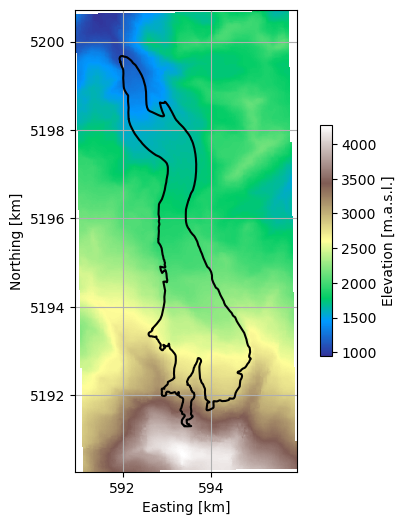

In [12]:
# -----Load AOI as gpd.GeoDataFrame
AOI = gpd.read_file(AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs('EPSG:4326')
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))
# reproject AOI to the optimal UTM zone
AOI_UTM = AOI.to_crs('EPSG:'+epsg_UTM)

# -----Load DEM as Xarray DataSet
if DEM_fn is None:
    # query GEE for DEM
    DEM = f.query_gee_for_dem(AOI_UTM, base_path, site_name, DEM_path)
else:
    # load DEM as xarray DataSet
    DEM = xr.open_dataset(DEM_path + DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # set no data values to NaN
    DEM = xr.where((DEM > 1e38) | (DEM <= -9999), np.nan, DEM)
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject('EPSG:'+str(epsg_UTM)).rio.write_crs('EPSG:'+str(epsg_UTM))

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(DEM.elevation.data, cmap='terrain', 
          extent=(np.min(DEM.x.data)/1e3, np.max(DEM.x.data)/1e3, np.min(DEM.y.data)/1e3, np.max(DEM.y.data)/1e3))
if type(AOI_UTM.geometry[0])==Polygon:
    ax.plot([x/1e3 for x in AOI_UTM.geometry[0].exterior.coords.xy[0]],
            [y/1e3 for y in AOI_UTM.geometry[0].exterior.coords.xy[1]], '-k')
elif type(AOI_UTM.geometry[0])==MultiPolygon:
    [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
            [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in AOI_UTM.geometry[0].geoms]
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m.a.s.l.]')
plt.show()

In [13]:
# -----Load classified image file names
im_classified_fns = sorted([os.path.basename(x) for x in glob.glob(im_classified_path +'*.nc')])
im_classified_fns

['20130516T125738_Carbon_Landsat_classified.nc',
 '20130601T125742_Carbon_Landsat_classified.nc',
 '20130610T125128_Carbon_Landsat_classified.nc',
 '20130703T125738_Carbon_Landsat_classified.nc',
 '20130719T125736_Carbon_Landsat_classified.nc',
 '20130820T125740_Carbon_Landsat_classified.nc',
 '20130914T125127_Carbon_Landsat_classified.nc',
 '20131023T125726_Carbon_Landsat_classified.nc',
 '20140512T124903_Carbon_Landsat_classified.nc',
 '20140519T125510_Carbon_Landsat_classified.nc',
 '20140604T125517_Carbon_Landsat_classified.nc',
 '20140706T125528_Carbon_Landsat_classified.nc',
 '20140807T125540_Carbon_Landsat_classified.nc',
 '20141010T125551_Carbon_Landsat_classified.nc',
 '20150607T125451_Carbon_Landsat_classified.nc',
 '20150623T125458_Carbon_Landsat_classified.nc',
 '20150709T125509_Carbon_Landsat_classified.nc',
 '20150911T125533_Carbon_Landsat_classified.nc',
 '20150927T125539_Carbon_Landsat_classified.nc',
 '20151013T125539_Carbon_Landsat_classified.nc',
 '20160501T124905_Ca

In [14]:
# delete old snowline files
fns = sorted(glob.glob(snowlines_path + '*.csv'))
fns
for fn in fns:
    os.remove(fn)

In [15]:
# delete old figure files
fns = sorted(glob.glob(figures_out_path + '*.png'))
fns
for fn in fns:
    os.remove(fn)

In [16]:
# define function to delineate snowlines
def apply_delineate_snowline(im_classified_path, im_classified_fn, site_name, dataset, figures_out_path, snowlines_path):
    
    # load classified image
    im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
    # remove no data values
    im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
    im_classified = im_classified.rio.write_crs('EPSG:4326')
    im_classified = im_classified.rio.reproject('EPSG:' + str(AOI_UTM.crs.to_epsg()))

    # determine image date and dataset
    im_date = im_classified_fn[0:15]
    im_dt = np.datetime64(im_date[0:4] + '-' + im_date[4:6] + '-' + im_date[6:8])
    dataset = im_classified_fn.split(site_name + '_')[1].split('_classified')[0]

    # check whether snowline exists in file
    snowline_fn = im_date + '_' + site_name + '_' + dataset + '_snowline.csv'
    if not os.path.exists(snowlines_path + snowline_fn):
        # delineate snowline and set up figure
        snowline_df = f.delineate_snowline(im_classified, site_name, AOI_UTM, DEM, dataset_dict, dataset, im_date, snowline_fn,
                                           snowlines_path, figures_out_path, plot_results=True, im_xr=None, verbose=False)
        plt.close()

Sentinel-2_TOA
[##########                              ] | 27% Completed | 100.68 s


EEException: Image.clip: Parameter 'input' is required.

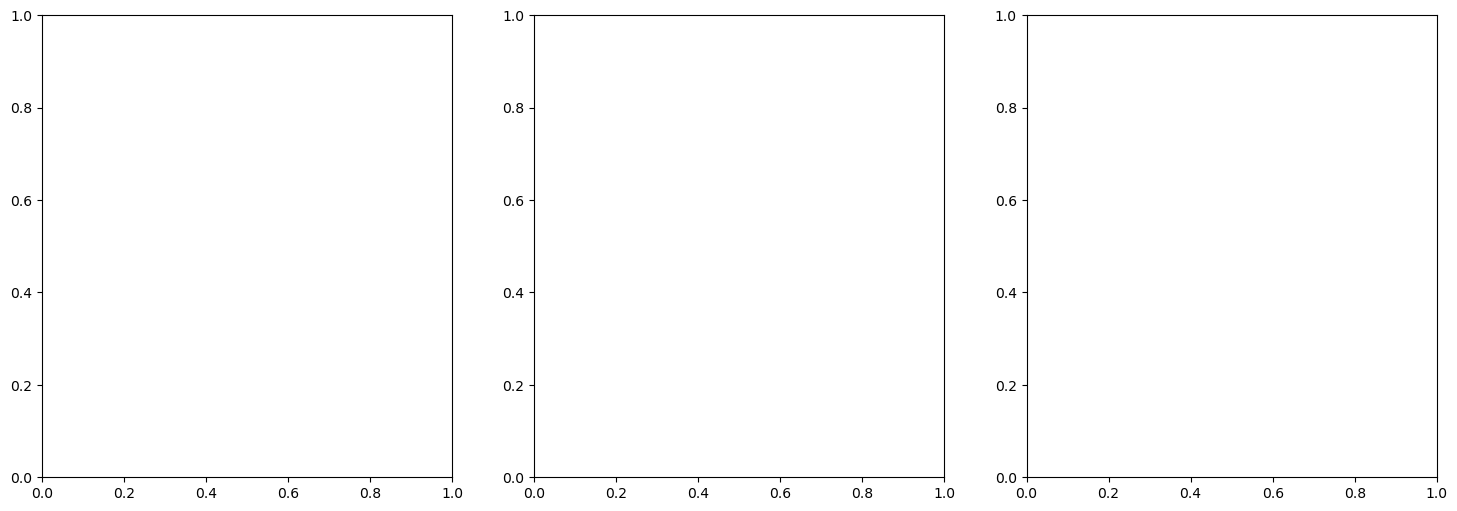

In [31]:
datasets = ['Sentinel-2_TOA', 'Sentinel-2_SR', 'Landsat']

for dataset in datasets:
    
    print(dataset)
    
    im_classified_fns_dataset = [x for x in im_classified_fns if dataset in x]
    # Run the function for all classified image file names
    im_classified_fns_bag = db.from_sequence(im_classified_fns_dataset)
    def process_file_delayed(im_classified_fn):
        return apply_delineate_snowline(im_classified_path, im_classified_fn, site_name, dataset, figures_out_path, snowlines_path)
    
    result_bag = im_classified_fns_bag.map(process_file_delayed)
    
    # Wrap the computation with tqdm to display a progress bar
    with ProgressBar():
        results = dask.compute(result_bag, scheduler="threads", num_workers=1)  # Adjust scheduler and num_workers as needed
